In [884]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import transforms, pyplot as plt
%matplotlib inline

from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [732]:
data = pd.read_csv("http://www-stat.stanford.edu/~tibs/ElemStatLearn/datasets/SAheart.data",
                  index_col=0)
data['famhist'] = pd.get_dummies(data['famhist'])['Present']
data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
row.names,,,,,,,,,,
1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [733]:
cols = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'age']
target = 'chd'

## Defining my functions

In [734]:
def spline(X, dof, natural):
    
    '''
    X: nx1 array
    dof: degrees of freedom
    natural: boolean, if True, implement natural spline;
                      if False, implement truncated power spline;
    
    return: spline basis of X
    
    '''
    
    if natural:
        # interior knots + boundary knots = dof, 
        # implement natural spline
        quantiles = np.linspace(0, 1, dof)
        knots = [np.quantile(X, quantile) for quantile in quantiles]

        ones = np.ones(len(X)).reshape(-1,1)
        basis_splines = [ones, X]
        dk_last = ((X-knots[-2]).clip(0)**3 - (X-knots[-1]).clip(0)**3) / (knots[-1] - knots[-2])

        for knot in knots[:-2]:
            dk = ((X-knot).clip(0)**3 - (X-knots[-1]).clip(0)**3) / (knots[-1] - knot)
            basis_splines.append(dk - dk_last)
     
    else:
        # interior knots = dof
        # implement truncated power spline
        quantiles = np.linspace(0, 1, dof+2)
        knots = [np.quantile(X, quantile) for quantile in quantiles][1:-1]
        
        ones = np.ones(len(X)).reshape(-1,1)
        basis_splines = [ones, X, X**2, X**3]
        
        for knot in knots:
            h = (X - knot).clip(0)**3
            basis_splines.append(h)
        
    basis = np.hstack(basis_splines)
    
    return basis

In [735]:
def basis_expansion(method, X, n_knots):
    
    # scale X
    scaler1 = StandardScaler()
    X_scaled = scaler1.fit_transform(X)
    
    if col == 'famhist':
        X_new = X_scaled.copy()
        return X_new
    
    if method == "b-spline":
        quantiles = np.linspace(0, 1, n_knots)
        knots = [np.quantile(X_scaled, quantile) for quantile in quantiles]
        X_new = dmatrix(f"bs(X, knots={knots}, include_intercept=True)", 
                {"X": X_scaled},return_type='dataframe').values
   
    else:
        
        if method == "natural spline":
            natural = True
        elif method == "truncated power spline":
            natural = False
        X_transformed = spline(X=X_scaled, dof=n_knots, natural=natural)
        scaler2 = StandardScaler()
        X_new = scaler2.fit_transform(X_transformed)
    
    return X_new

## Q1

I've tried my best to replicate figure 5.4. I believe the difference is due to the fact that, in the book the spline coefficients of each variable were obtained from the full model fitted on the bases of all variables followed by feature selection. However, I fitted the Logistic Regression model on each expanded variable separately and obtained their respective coefficients. 

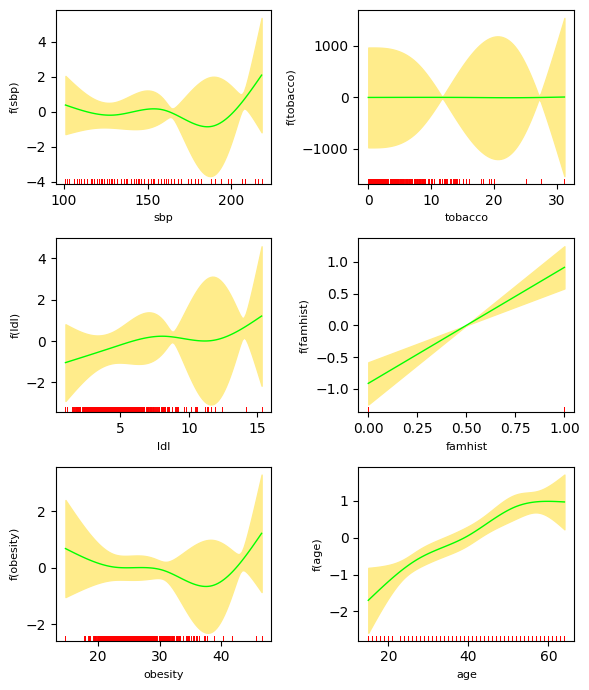

In [736]:
fig, axes = plt.subplots(3, 2, figsize=(6, 7))
axes = axes.flatten()


for ax, col in zip(axes, cols):
    
    # sort X in ascending order
    df = data[[col, target]].copy()
    df.sort_values(by=col, ascending=True, inplace=True)
    X = df[col].values.reshape(-1, 1)
    X_spaced = np.linspace(X.min(), X.max(), 100).reshape(-1,1)
    y = df[target].values

    # X for fitting the model
    X_fit = basis_expansion("natural spline", X, 5)
    # X for plotting
    X_exp = basis_expansion("natural spline", X_spaced, 5)
    if col != 'famhist':
        X_fit = X_fit[:,1:]
        X_exp = X_exp[:,1:]
    
    # fit logistic regression to X_fit and y
    model = LogisticRegression(solver='lbfgs', max_iter=100000, C=10e10, fit_intercept=False)
    model.fit(X_fit, y)
    
    # calculate predictions
    coefs = model.coef_.T
    y_pred = np.squeeze(X_exp @ coefs)
    
    # calculate err = 2 * se
    predProbs = model.predict_proba(X_fit)
    W = np.diagflat(np.product(predProbs, axis=1))
    H = X_fit.copy()
    cov = np.linalg.inv(H.T @ W @ H)
    err = 2 * np.sqrt(np.diag(X_exp @ cov @ X_exp.T))
    
    # calculate upper bound and lower bound of predictions
    y_pred_up = y_pred + err
    y_pred_low = y_pred - err
    
    # plotting
    ax.fill_between(np.squeeze(X_spaced,1), y_pred_low, y_pred_up, color='#FFEC8B')
    ax.plot(np.squeeze(X_spaced,1), y_pred, color='#00FF00', linewidth=1)
    y_start, y_end = ax.get_ylim()

    for i in range(X.shape[0]):
        x = X[i]
        ax.plot([x,x], [y_start, y_start+(y_end-y_start)*0.03], color='red', linewidth=0.7)
    ax.set_ylim(y_start, y_end)
    ax.set_xlabel(col, fontsize=8)
    ax.set_ylabel(f"f({col})", fontsize=8)

fig.tight_layout()

## Q2

In [742]:
col = 'tobacco'
df = data[[col, target]].copy()
df.sort_values(by=col, ascending=True, inplace=True)
X = df[col].values.reshape(-1, 1)
y = df[target]

In [743]:
X_bs = basis_expansion(method="b-spline", X=X, n_knots=5)
X_ns = basis_expansion(method="natural spline", X=X, n_knots=5)
X_tps = basis_expansion(method="truncated power spline", X=X, n_knots=5)

In [744]:
X_bs.shape, X_ns.shape, X_tps.shape

((462, 10), (462, 5), (462, 9))

In [745]:
np.array(y).reshape(-1,1).shape

(462, 1)

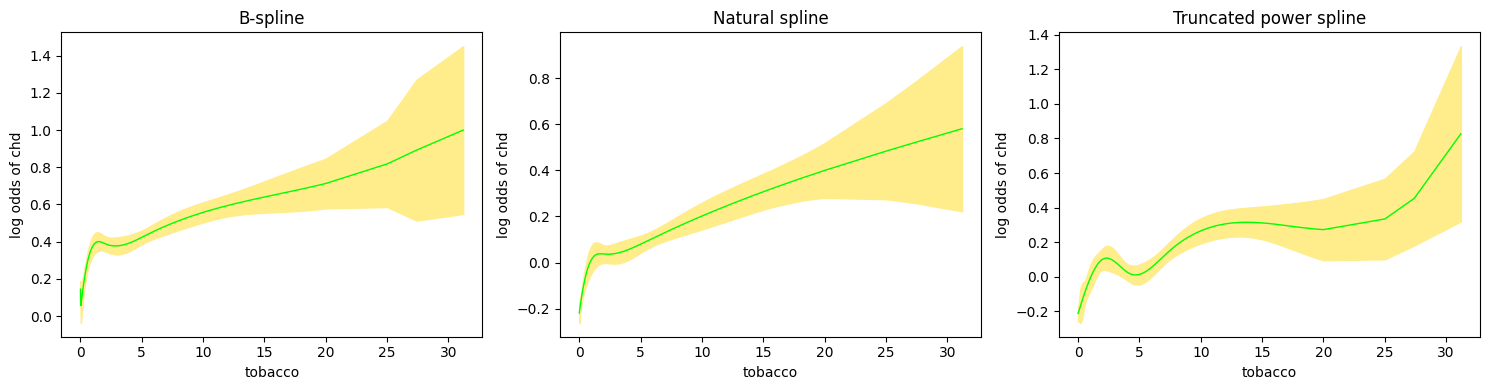

In [749]:
fig = plt.figure(figsize=(15, 4))

X_exps = [X_bs, X_ns, X_tps]
titles = ['B-spline', 'Natural spline', 'Truncated power spline']

for i, (title, X_exp) in enumerate(zip(titles, X_exps)):
    
    model = sm.GLM(np.array(y).reshape(-1,1), X_exp).fit()
    coefs = np.array(model.params).reshape(-1,1)
    cov = model.cov_params()
    
    y_pred = np.squeeze(X_exp @ coefs)
    err = np.sqrt(np.diag(X_exp @ cov @ X_exp.T))
    
    plt.subplot(1, 3, i+1)
    plt.fill_between(np.squeeze(X,1), y_pred-err, y_pred+err, color='#FFEC8B')
    plt.plot(np.squeeze(X,1), y_pred, color='#00FF00', linewidth=1)
    plt.title(title)
    plt.xlabel("tobacco")
    plt.ylabel("log odds of chd")

plt.tight_layout()

## Q3

In [750]:
def spline(X, dof, natural):
    
    '''
    X: nx1 array
    dof: degrees of freedom
    natural: boolean, if True, implement natural spline;
                      if False, implement truncated power spline;
    
    return: spline basis of X
    
    '''
    
    if natural:
        # interior knots + boundary knots = dof, 
        # implement natural spline
        quantiles = np.linspace(0, 1, dof)
        knots = [np.quantile(X, quantile) for quantile in quantiles]

        ones = np.ones(len(X)).reshape(-1,1)
        basis_splines = [ones, X]
        dk_last = ((X-knots[-2]).clip(0)**3 - (X-knots[-1]).clip(0)**3) / (knots[-1] - knots[-2])

        for knot in knots[:-2]:
            dk = ((X-knot).clip(0)**3 - (X-knots[-1]).clip(0)**3) / (knots[-1] - knot)
            basis_splines.append(dk - dk_last)
     
    else:
        # interior knots = dof
        # implement truncated power spline
        quantiles = np.linspace(0, 1, dof+2)
        knots = [np.quantile(X, quantile) for quantile in quantiles][1:-1]
        
        ones = np.ones(len(X)).reshape(-1,1)
        basis_splines = [ones, X, X**2, X**3]
        
        for knot in knots:
            h = (X - knot).clip(0)**3
            basis_splines.append(h)
        
    basis = np.hstack(basis_splines)
    
    return basis

In [751]:
col = 'age'
dof = 5
df = data[[col, target]].copy()
df.sort_values(by=col, ascending=True, inplace=True)
X = df[col].values.reshape(-1, 1)

In [752]:
regular_basis = spline(X, dof, natural=False)
natural_basis = spline(X, dof, natural=True)

In [753]:
scaler = StandardScaler()
regular_basis_scaled = scaler.fit_transform(regular_basis)
natural_basis_scaled = scaler.fit_transform(natural_basis)

In [754]:
regular_basis_scaled.shape, natural_basis_scaled.shape

((462, 9), (462, 5))

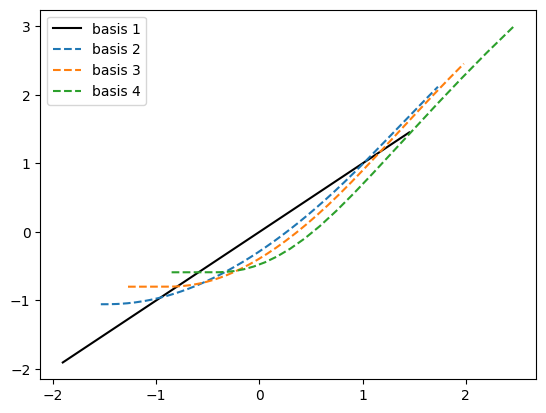

In [755]:
plt.plot(regular_basis_scaled[:,1], natural_basis_scaled[:,1], c='black',label='basis 1')
plt.plot(regular_basis_scaled[:,2], natural_basis_scaled[:,2], '--',label='basis 2')
plt.plot(regular_basis_scaled[:,3], natural_basis_scaled[:,3], '--',label='basis 3')
plt.plot(regular_basis_scaled[:,4], natural_basis_scaled[:,4], '--',label='basis 4')
plt.legend(loc='best')

## Q4

Write a function to simulate data drawn from a smooth two-dimensional surface on the unit square with Gaussian noise using a mixture model.

In [854]:
from scipy.stats import multivariate_normal
from scipy.interpolate import RectBivariateSpline
from sklearn.metrics import mean_squared_error

In [860]:
means = np.array([[0.2, 0.2], [0.5, 0.7], [0.8, 0.3]])
covs = np.array([[[0.01, 0], [0, 0.01]], 
                 [[0.03, -0.02], [-0.02, 0.03]], 
                 [[0.02, 0], [0, 0.02]]])
weights = np.array([0.4, 0.3, 0.3])

def f(x, y):
    
    '''
    pdf of the Gaussian mixture
    '''
    
    pdf = 0
    for i in range(3):
        pdf += weights[i] * multivariate_normal.pdf((x,y),mean=means[i],cov=covs[i])
    
    return pdf

In [873]:
def simulate_data(n_samples):
    
    noise_std = np.random.uniform(0, 0.3)
    
    x = np.linspace(0, 1, n_samples)
    y = np.linspace(0, 1, n_samples)
    z = np.zeros((len(x), len(y)))
    
    for i in range(len(x)):
        for j in range(len(y)):
            z[i,j] = f(x[i], y[j])

    z += np.random.normal(scale=noise_std, size=z.shape)

    return x, y, z

In [889]:
mse = 0
residual = 0 # sum of squared residuals of the spline approximation
t = 0
for i in range(250):
    
    x, y, z = simulate_data(100)
    z_true = np.zeros(len(x))
    for i in range(len(x)):
        z_true[i] = f(x[i], y[i])
    
    start = time.time()
    spline = RectBivariateSpline(x, y, z)
    end = time.time()
    z_pred = spline.ev(x, y)
    
    residual += spline.get_residual()
    mse += mean_squared_error(z_true, z_pred)
    t += (end-start)

**Note: Python library for fitting 2-d spline is different from R's, so I wasn't able to implement the two methods in the question.**

In [896]:
print(f"Average computation time = {np.round(t/250, 5)}")
print(f"Average bias = {np.round(residual/250, 5)}")
print(f"Average variance = {np.round((mse-residual)/250, 5)}")
print(f"Average MSE = {np.round(mse/250, 5)}")

Average computation time = 0.00054
Average bias = 0.0
Average variance = 0.03009
Average MSE = 0.03009
